In [1]:
import os
import scipy
import warnings
import math

import pandas            as pd
import matplotlib.pyplot as plt
import numpy             as np
import seaborn           as sns
import scipy.stats       as stats

from scipy.optimize    import curve_fit
from scipy.stats.stats import pearsonr
from datetime       import datetime

from tqdm import tqdm_notebook as tqdm

def func_linear(x, k, c):
    return k*x+c
def func_gauss(x, sigm, mu, A):
    return np.exp(-((x-mu)**2)/(2*sigm**2))*A
warnings.simplefilter('ignore')

In [2]:
PATH = r"D:\INR\variations\MEPHI10-18"

# Чтение данных за годы с установки и запись их в файл: давление и темп счета нейтронов (2012 - 2018)

Измерения с детекторов снимаются раз в 5 минут. Соответсвенно можно усреднять показания по 30 минут, 1 и 2 часам

In [3]:
new_names = ['Neutr1', 'Neutr2', 'Neutr3', 'Neutr4','Pressure', 'T, C', 'Humidity']
Itog = pd.DataFrame(columns = new_names)

#Чтение данных
for I in tqdm(range(12,19,1)):
    directory = PATH+ r"/20%s" %str(I)
    files = os.listdir(directory) 
    for i in (files):
        s=str(i)
        if (len(s)== 10):
            data1 = pd.read_csv(PATH+ r"\20%s\%s" %(str(I),i), names = new_names, delim_whitespace = True, 
                                usecols = [1,2,3,4,9,10,11])
            
            data1['D'] = int( s[5:7:1] )
            data1['M'] = int( s[2:4:1] )
            data1['Y'] = int( '20'+s[8:] )
            
            data1.drop_duplicates(subset = 'Pressure', keep = 'first', inplace = True)
            data1.drop_duplicates(subset = 'T, C',     keep = 'first', inplace = True)
            data1.drop_duplicates(subset = 'Humidity', keep = 'first', inplace = True)
            
            for d in range(0,data1.shape[0],1):
                data1.loc[d, 'H'] = (d//12)
                
            for d in range(0,(data1.shape[0]//24),1):
                data1.loc[data1['H'] == d, 'Neutr1'] = data1[data1['H'] == d]['Neutr1'].mean()
                data1.loc[data1['H'] == d, 'Neutr2'] = data1[data1['H'] == d]['Neutr2'].mean()
                data1.loc[data1['H'] == d, 'Neutr3'] = data1[data1['H'] == d]['Neutr3'].mean()
                data1.loc[data1['H'] == d, 'Neutr4'] = data1[data1['H'] == d]['Neutr4'].mean()
                                        
            data1.drop_duplicates(subset = 'H', keep = 'first', inplace = True)   
            data1.dropna(inplace = True)
            Itog = pd.merge(Itog, data1, how = 'outer')
    Itog = Itog[Itog['Neutr1']>0][Itog['Neutr2']>0][Itog['Neutr3']>0][Itog['Neutr4']>0][Itog['H']<24]
    
    #Запись данных в файл                
    Itog.to_csv(PATH+ r"/Result_onlydata_1h.txt", sep = ' ', header = False, index = False, mode ='a+') 
    Itog = pd.DataFrame(columns = new_names)    
    
# Для часового разбиения
new_names = ['Neutr1', 'Neutr2', 'Neutr3', 'Neutr4','Pressure', 'T, C', 'Humidity', 'D', 'M', 'Y', 'H']
Itog = pd.read_csv(PATH+ r"\Result_onlydata_1h.txt", names = new_names, delim_whitespace = True)
Itog['date'] = pd.to_datetime(Itog.apply(lambda x: str(int(x['D']))+'-'+str(int(x['M']))+'-'+str(int(x['Y']))+' '+str(int(x['H']))+':'+str(0),
                                        axis=1), format = "%d-%m-%Y %H:%M", yearfirst = False, dayfirst = True)
# Для часового разбиения

#Для получсаового и двух часового разбиения
# new_names = ['Neutr1', 'Neutr2', 'Neutr3', 'Neutr4','Pressure', 'T, C', 'Humidity', 'D', 'M', 'Y', 'H']
# Itog = pd.read_csv(r"D:\variations\MEPHI10-18\Result_onlydata_2h.txt", names = new_names, delim_whitespace = True)
# Itog['date'] = pd.to_datetime(Itog.apply(lambda x: str(int(x['D']))+'-'+str(int(x['M']))+'-'+str(int(x['Y'])),axis=1), 
#                               format = "%d-%m-%Y", yearfirst = False, dayfirst = True)  
#Для получсаового и двух часового разбиения

Itog = Itog[Itog['date']<'2018-05-01']
Itog.to_csv(PATH+ r"/1h/Result_onlydata_1h.txt", sep = ' ', header = False, index = False, mode ='w') 

for i in range(2012,2019,1):
    for j in range(1,5,1):
        plt.figure(figsize = (20, 10))
        plt.plot(Itog[Itog['Y']==i]['date'],Itog[Itog['Y']==i]['Neutr%s'%j],'.')
        plt.grid(True, linestyle='--', color='0.75')
        plt.savefig(PATH+ r"/pictures/%s/real_data_det%s.png" %(str(i), str(j) )) 
        plt.close()
        
# За все время
for j in range(1,5,1):
    plt.figure(figsize = (20, 10))
    plt.plot(Itog['date'],Itog['Neutr%s'%j],'.')
    plt.grid(True, linestyle='--', color='0.75')
    plt.savefig(PATH+ r"/pictures/%s/real_data_all_det%s.png" %(str(i), str(j) )) 
    plt.close()

  0%|          | 0/7 [00:00<?, ?it/s]

## Чистка предварительная (уходят выбросы в каждом детекторе)

In [4]:
new_names = ['Neutr1', 'Neutr2', 'Neutr3', 'Neutr4','Pressure', 'T, C', 'Humidity', 'D', 'M', 'Y', 'H', 'date']
Itog = pd.read_csv(PATH+ r"\1h\Result_onlydata_1h.txt", names = new_names, delim_whitespace = True)
# Для часового разбиения
Itog['date'] = pd.to_datetime(Itog.apply(lambda x: str(int(x['D']))+'-'+str(int(x['M']))+'-'+str(int(x['Y']))+' '+str(int(x['H']))+':'+str(0),
                                         axis=1), format = "%d-%m-%Y %H:%M", yearfirst = False, dayfirst = True)
# Для часового разбиения
# Чистка по первому детектору
    # 2012
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2012)&(Itog['Neutr1']<76)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2012)&(Itog['Neutr1']>120)) ].index)
    # 2013 
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2013)&(Itog['Neutr1']<80)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2013)&(Itog['Neutr1']>120)) ].index)
    # 2014
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2014)&(Itog['Neutr1']<75)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2014)&(Itog['Neutr1']>125)) ].index)
    # 2015
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2015)&(Itog['Neutr1']<75)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2015)&(Itog['Neutr1']>120)) ].index)
    # 2016
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2016)&(Itog['Neutr1']<85)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2016)&(Itog['Neutr1']>120)) ].index)
    # 2017
Itog = Itog.drop(Itog.loc[ ( (Itog['date']<'25-08-2017 0:0')&(Itog['Neutr1']<80) &(Itog['date']>='01-01-2017 0:0') ) ].index)
Itog = Itog.drop(Itog.loc[ ( (Itog['date']<'25-08-2017 0:0')&(Itog['Neutr1']>120)&(Itog['date']>='01-01-2017 0:0') ) ].index)
Itog = Itog.drop(Itog.loc[ ( (Itog['date']>'25-08-2017 0:0')&(Itog['Neutr1']>160)&(Itog['date']<'01-01-2018 0:0') ) ].index)
Itog = Itog.drop(Itog.loc[ ( (Itog['date']>'25-08-2017 0:0')&(Itog['Neutr1']>100)&(Itog['date']<'01-01-2018 0:0') ) ].index)
    # 2018
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2018)&(Itog['Neutr1']<100)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2018)&(Itog['Neutr1']>150)) ].index)
# Чистка по первому детектору



# Чистка по второму детектору
    # 2012
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2012)&(Itog['Neutr2']<275)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2012)&(Itog['Neutr2']>450)) ].index)
    # 2013
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2013)&(Itog['Neutr2']<280)&(Itog['M']<=4) ) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2013)&(Itog['Neutr2']>450)&(Itog['M']<=4) ) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2013)&(Itog['Neutr2']>450)&(Itog['M']>=7)&(Itog['M']<12)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2013)&(Itog['Neutr2']<280)&(Itog['M']>=7)&(Itog['M']<12)) ].index)
    # 2014
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2014)&(Itog['Neutr2']<250)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2014)&(Itog['Neutr2']>500)) ].index)
    # 2015
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2015)&(Itog['Neutr2']>430)) ].index)
    # 2016
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2016)&(Itog['Neutr2']<260)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2016)&(Itog['Neutr2']>440)) ].index)
    # 2017
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2017)&(Itog['Neutr2']<275)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2017)&(Itog['Neutr2']>500)) ].index)  
    # 2018
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2018)&(Itog['Neutr2']<280)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2018)&(Itog['Neutr2']>450)) ].index)
# Чистка по второму детектору



# Чистка по третьему детектору
    # 2012
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2012)&(Itog['Neutr3']<225)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2012)&(Itog['Neutr3']>390)) ].index)
    # 2013
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2013)&(Itog['Neutr3']<275)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2013)&(Itog['Neutr3']>390)) ].index)
    # 2014
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2014)&(Itog['Neutr3']<230)) ].index)
    # 2015
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2015)&(Itog['Neutr3']<250)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2015)&(Itog['Neutr3']>400)) ].index)
    # 2016
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2016)&(Itog['Neutr3']<290)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2016)&(Itog['Neutr3']>400)) ].index)
    # 2017
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2017)&(Itog['Neutr3']<275)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2017)&(Itog['Neutr3']>450)) ].index)
    # 2018
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2018)&(Itog['Neutr3']<280)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2018)&(Itog['Neutr3']>420)) ].index)
# Чистка по третьему детектору



# Чистка по четвертому детектору
    # 2012
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2012)&(Itog['Neutr4']<250)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2012)&(Itog['Neutr4']>430)) ].index)
    # 2013
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2013)&(Itog['Neutr4']<270)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2013)&(Itog['Neutr4']>400)) ].index)
    # 2014
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2014)&(Itog['Neutr4']<250)) ].index)
    # 2016
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2016)&(Itog['Neutr4']<340)) ].index)
    # 2017
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2017)&(Itog['Neutr4']<340)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2017)&(Itog['Neutr4']>575)) ].index)
    # 2018
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2018)&(Itog['Neutr4']<375)) ].index)
Itog = Itog.drop(Itog.loc[ ((Itog['Y']==2018)&(Itog['Neutr4']>540)) ].index)
# Чистка по четвертому детектору


# Построение графиков очищенного темпа счета по годам
for i in tqdm( range(2012,2019,1) ):
    for j in range(1,5,1):
        plt.figure(figsize = (20, 10))
        plt.plot(Itog[Itog['Y']==i]['date'],Itog[Itog['Y']==i]['Neutr%s'%j],'.')
        plt.grid(True, linestyle='--', color='0.75')
        plt.savefig(PATH+ r"/pictures/%s/real_data_clear_det%s.png" %( str(i),str(j) )  ) 
        plt.close()

# Усреднение данных за месяц 
'''
for i in tqdm( range (2012,2019,1) ):
    for j in range(1,13,1):
        if (Itog[Itog['Y']==i][Itog['M']==j].shape[0]>1):
            Itog.loc[(Itog['Y']==i)&(Itog['M']==j),'Neutr1'] = Itog[Itog['Y']==i][Itog['M']==j]['Neutr1']/Itog[Itog['Y']==i][Itog['M']==j]['Neutr1'].mean()
            
            Itog.loc[(Itog['Y']==i)&(Itog['M']==j),'Neutr2'] = Itog[Itog['Y']==i][Itog['M']==j]['Neutr2']/Itog[Itog['Y']==i][Itog['M']==j]['Neutr2'].mean()
            
            Itog.loc[(Itog['Y']==i)&(Itog['M']==j),'Neutr3'] = Itog[Itog['Y']==i][Itog['M']==j]['Neutr3']/Itog[Itog['Y']==i][Itog['M']==j]['Neutr3'].mean()
            
            Itog.loc[(Itog['Y']==i)&(Itog['M']==j),'Neutr4'] = Itog[Itog['Y']==i][Itog['M']==j]['Neutr4']/Itog[Itog['Y']==i][Itog['M']==j]['Neutr4'].mean()
            
Itog = Itog[Itog['Neutr1']<2][Itog['Neutr2']<2][Itog['Neutr3']<2][Itog['Neutr4']<2]
'''
Itog.to_csv(PATH+ r"/1h/Result_corrected_step1_1h.txt", sep = ' ', header = False, index = False, mode ='w')        

  0%|          | 0/7 [00:00<?, ?it/s]

### Построение графиков для барометрического коэффициента
### Очистка данных в пределах 3 сигм

In [30]:
new_names = ['Neutr1', 'Neutr2', 'Neutr3', 'Neutr4','Pressure', 'T, C', 'Humidity', 'D', 'M', 'Y', 'H','date']
Itog = pd.read_csv(PATH+ r"\1h\Result_corrected_step1_1h.txt", names = new_names, delim_whitespace = True)
Itog['date'] = pd.to_datetime(Itog['date'])
# Для часового разбиения
allcoeff = pd.DataFrame()
otrez = pd.DataFrame()

print('Границы для 3 сигм')
#Постороение гистограмм по темпу счета
for i in range(1,5,1):
    plt.figure(figsize = (15, 15))
    plt.grid(True, linestyle='--', color='0.75')
    plt.xlabel('Относительный темп счета', size = '14')
    plt.ylabel('Число таких значений', size = '14')
    plt.title('Распределение темпа счета для детектора %s' %i, size = '16')
    xdata=np.linspace(Itog['Neutr%s'%i].min(), Itog['Neutr%s'%i].max(), num=100)
    ydata=(Itog['Neutr%s'%i].value_counts(normalize=False, sort=False, ascending = True, bins=100, dropna=False))
    plt.step(xdata, ydata, 'g', label = u'Исходные данные', where = 'mid', linewidth = 3)    
    
    #Все данные
    newx = np.linspace(Itog['Neutr%s'%i].min(), Itog['Neutr%s'%i].max(), num=100)
    popt, pcov = curve_fit(func_gauss, xdata, ydata, p0=[10, xdata.mean(), 5000])#, method = 'lm')
    plt.plot(newx, func_gauss(newx, *popt), 'r-', label=u'Аппроксимация Гауссом',linewidth = 3)  
    
    #Скорректированные данные
    beg = Itog[Itog['Neutr%s'%i]>=(popt[1]-3*math.fabs(popt[0]))][Itog['Neutr%s'%i]<=(popt[1]+3*math.fabs(popt[0]))]['Neutr%s'%i].min()
    end = Itog[Itog['Neutr%s'%i]>=(popt[1]-3*math.fabs(popt[0]))][Itog['Neutr%s'%i]<=(popt[1]+3*math.fabs(popt[0]))]['Neutr%s'%i].max()
    otrez.loc['beg', i] = beg
    otrez.loc['end', i] = end
    newx = np.linspace(beg, end, num=100)
    plt.plot(newx, func_gauss(newx, *popt), 'b-', label=u'Используемые данные', linewidth = 3)
    plt.legend(title='Обозначения')
    
    #Доп инфа
    plt.text(1.2,ydata.max()/2+500, 'Сигма %f' %(math.fabs(popt[0])),size = '14')
    plt.text(1.2,ydata.max()/2, 'Среднее %f' %(popt[1]), size = '14')
    plt.text(1.2,ydata.max()/2-500, '(%f;%f)' %(beg,end), size = '14')
    print(beg, end)
    plt.savefig(PATH+ r"/pictures/3sigmas-det_%s.png" %i ) 
    plt.close()

    
# Чистка в пределах 3 сигм
print("ITOG", Itog.shape)
Itog = Itog[Itog['Neutr1']>=otrez.loc['beg',1]]
Itog = Itog[Itog['Neutr2']>=otrez.loc['beg',2]]
Itog = Itog[Itog['Neutr3']>=otrez.loc['beg',3]]
Itog = Itog[Itog['Neutr4']>=otrez.loc['beg',4]]
Itog = Itog[Itog['Neutr1']<=otrez.loc['end',1]]
Itog = Itog[Itog['Neutr2']<=otrez.loc['end',2]]
Itog = Itog[Itog['Neutr3']<=otrez.loc['end',3]]
Itog = Itog[Itog['Neutr4']<=otrez.loc['end',4]]
print("ITOG", Itog.shape)
print(otrez)

# Построение барометрического коэффициента для для каждого месяца из данных
index = 0
for l in tqdm( range (2012,2019,1) ):
    for i in range (1,13,1):
        if ( Itog[Itog['M'] == i][Itog['Y'] == l].shape[0] > 1 ) :
            plt.figure(figsize = (21, 21))
            
            for j in range(1,5,1):

                y = Itog[Itog['M'] == i][Itog['Y'] == l]['Neutr%s'%j]
                x = Itog[Itog['M'] == i][Itog['Y'] == l]['Pressure' ]
                popt, pcov = curve_fit(func_linear,x,y)
                dis = np.linspace(x.min(),x.max(),num=100)
                allcoeff.loc[index, 'Neutr%s'%j] = popt[0]
                allcoeff.loc[index, 'Err%s'%j] = pcov[0,0]**(1/2)
                allcoeff.loc[index, 'date'] = pd.to_datetime(str(i) + '-' + str(l))
                
                plt.subplot(2,2,j)
                plt.grid(True, linestyle='--', color='0.75')
                plt.xlabel('Давление, мм рт ст', size = '14')
                plt.ylabel('Относительный темп счета', size = '14')
                plt.title('Рассчеты для детектора с номером %d' %(j), size = '16')
                plt.plot(x, y, '.', label = u'Реальные значения')
                plt.text(x.min(), y.min() + 0.08*y.min() , 'y = %f*x + %f' %(popt[0], popt[1]), size = '14')
                plt.plot(dis, popt[0]*(dis) + popt[1], 'r', label=u'Аппроксимация прямой', linewidth = 3)
                plt.legend(title='Обозначения:')
                
            plt.savefig(PATH+ r"/pictures/%s/bar_coef_month%s.png" %(str(l),str(i))) 
            plt.close()
            index +=1
            

#Постороение темпа счета по времени
for i in range(1,5,1):
    plt.figure(figsize = (21, 10))
    plt.grid(True, linestyle='--', color='0.75')
    plt.xlabel('Время', size = '14')
    plt.ylabel('Относительный темп счета', size = '14')
    plt.title('Зависимость темпа счета от времени для детектора %s' %i, size = '16')
    plt.plot(Itog['date'],Itog['Neutr%s' %i],  '.')
    plt.savefig(PATH+ r"/pictures/N_abs-date-det_%s.png" %i ) 
    plt.close()
    
allcoeff.to_csv(PATH+ r"/barometric_coeff.txt", sep = ' ', header = False, index = False, mode ='w')
# Нахождение среднего значения барометрического коэффициента и его погрешности
allcoeff.dropna(inplace = True)
allcoeff = allcoeff[allcoeff['Neutr1'] < -0.00025][allcoeff['Neutr2'] < -0.00025][allcoeff['Neutr3'] < -0.00025][allcoeff['Neutr4'] < -0.00025]

for i in range(1,5,1):
    plt.figure(figsize = (15, 15))
    plt.grid(True, linestyle='--', color='0.75')
    plt.xlabel('Барометрический коэффициент', size = '14')
    plt.ylabel('Число таких значений', size = '14')
    plt.title('Распределение борометрического коэффициента для детектора %s' %i, size = '16')
    xdata=np.linspace(allcoeff['Neutr%s'%i].min(), allcoeff['Neutr%s'%i].max(), num=20)
    ydata=(allcoeff['Neutr%s'%i].value_counts(normalize=False, sort=False, ascending = True, bins=20, dropna=False))
    plt.step(xdata, ydata, 'g', label = u'Исходные данные', where = 'mid')
    plt.savefig(PATH+ r"/pictures/coeff-plot-det_%s.png" %i ) 
    plt.close()
    vzves_bar = sum( allcoeff['Neutr%s'%i]*(allcoeff['Neutr%s'%i]/allcoeff['Err%s'%i])**2/
                 sum((allcoeff['Neutr%s'%i]/allcoeff['Err%s'%i])**2) )
    
    allcoeff['weight%s' %i] = (allcoeff['Neutr%s'%i]/allcoeff['Err%s'%i])**2/sum((allcoeff['Neutr%s'%i]/allcoeff['Err%s'%i])**2)
    
    vzves_err = sum( allcoeff['Err%s'%i]*(allcoeff['Neutr%s'%i]/allcoeff['Err%s'%i])**2/
                 sum((allcoeff['Neutr%s'%i]/allcoeff['Err%s'%i])**2) )
    #print('Значение барометрического коэффициента%s %s + %s ' %(i, allcoeff['Neutr%s'%i], allcoeff['Err%s'%i].mean())  )  
    print('Значение барометрического коэффициента%s %s + %s ' %(i, vzves_bar,   vzves_err)  )
    

    
#Постороение графика зависимости барометрического коэффициента от времени
for i in range(1,5,1):
    plt.figure(figsize = (21, 10))
    plt.grid(True, linestyle='--', color='0.75')
    plt.xlabel('Время', size = '14')
    plt.ylabel('Барометрический коэффициент', size = '14')
    plt.title('Зависимость барометрического коэффициента от времени для детектора %s' %i, size = '16')
    plt.plot(allcoeff['date'],allcoeff['Neutr%s' %i],  '.', label = u'Реальные значения')
    plt.plot( 
        [allcoeff['date'].min(),allcoeff['date'].max()], 
        [allcoeff['Neutr%s'%i].mean(),allcoeff['Neutr%s'%i].mean()],
        '-', label = u'Среднее значение за все время'
    )
    plt.legend(title='Обозначения:')
    plt.savefig(PATH+ r"\pictures/PT-date-det_%s.png" %i ) 
    plt.close() 
Itog.to_csv(PATH+ r"\1h/Result_corrected_step1_average_1h.txt", sep = ' ', header = False, index = False, mode ='w')

Границы для 3 сигм
76.0 122.08333333333331
256.0 447.8333333333333
243.0 402.8333333333333
250.0 520.0
ITOG (70726, 12)
ITOG (68246, 12)
              1           2           3      4
beg   76.000000  256.000000  243.000000  250.0
end  122.083333  447.833333  402.833333  520.0


  0%|          | 0/7 [00:00<?, ?it/s]

Значение барометрического коэффициента1 -0.5874703560509996 + 0.03127693275760209 
Значение барометрического коэффициента2 -2.9993261456603455 + 0.07558016819983582 
Значение барометрического коэффициента3 -2.6236240946328384 + 0.06339873395797317 
Значение барометрического коэффициента4 -3.249027741907499 + 0.07302474188865733 


## Построение датафрейма очищенного
### Поправка на барометрический коэффициент

In [31]:
new_names = ['Neutr1', 'Neutr2', 'Neutr3', 'Neutr4','Pressure', 'T, C', 'Humidity', 'D', 'M', 'Y', 'H', 'date']
Itog = pd.read_csv(PATH+ r"\1h\Result_corrected_step1_average_1h.txt", names = new_names, delim_whitespace = True)
allcoeff = pd.DataFrame()
Itog['date'] = pd.to_datetime(Itog['date'])
# Расчет барометрического коэффициента
index = 0
for l in tqdm( range (2012,2019,1) ):
    for i in range (1,13,1):
        if ( Itog[Itog['M'] == i][Itog['Y'] == l].shape[0] > 1 ) :                        
            plt.figure(figsize = (21, 21))
                        
            for j in range(1,5,1):
                #Выделение данных
                y = Itog[Itog['M'] == i][Itog['Y'] == l]['Neutr%s'%j]
                x = Itog[Itog['M'] == i][Itog['Y'] == l]['Pressure' ]
                
                #Рассчет аппроксимации и нахождение барометрического коэффициента
                allcoeff.loc[index, 'date'] = pd.to_datetime(str(i) + '-' + str(l))
                popt, pcov = curve_fit(func_linear,x,y)
                allcoeff.loc[index, 'Neutr%s'%j] = popt[0]
                allcoeff.loc[index, 'Err%s'%j] = pcov[0,0]**(1/2)
                allcoeff.loc[index, 'B%s'%j] = popt[1]
                
                # Поправка на давление, нормировка
                Itog.loc[ (Itog['M'] == i) & (Itog['Y'] == l),'Neutr%s'%j] = y - popt[0]*x*y + y*popt[0]*Itog[Itog['M'] ==i][Itog['Y']==l]['Pressure'].mean()
                beg_mean = Itog[Itog['M'] ==i][Itog['Y']==l]['Neutr%s'%j].mean()                
                Itog.loc[ (Itog['M'] == i) & (Itog['Y'] == l),'Neutr%s'%j] = Itog[Itog['M'] ==i][Itog['Y']==l]['Neutr%s'%j]/beg_mean
                
                #Построение поправленных данных для темпа счета
                plt.subplot(2,2,j)
                plt.grid(True, linestyle='--', color='0.75')
                plt.xlabel('Поправленнные данные с детектора %s' %j, size = '14')
                plt.ylabel('Число значений', size = '14')
                plt.title('Гистограмма по поправленным значениям относительного темпа счета', size = '16')
                xdata=np.linspace(Itog[Itog['M'] == i][Itog['Y'] == l]['Neutr%s'%j].min(), Itog[Itog['M'] == i][Itog['Y'] == l]['Neutr%s'%j].max(), num=20)
                ydata=(Itog[Itog['M'] == i][Itog['Y'] == l]['Neutr%s'%j].value_counts(normalize=False, sort=False, ascending = True, bins=20, dropna=False))
                plt.step(xdata, ydata, 'g', label = u'Исходные данные', where = 'mid')
            plt.savefig(PATH+ r"\pictures/%s/%s.png" %(str(l),str(i))) 
            plt.close()
            index +=1
            
Itog.to_csv(PATH+ r"/1h/Result_corrected_step2_average_1h.txt", sep = ' ', header = False, index = False, mode ='w')

  0%|          | 0/7 [00:00<?, ?it/s]

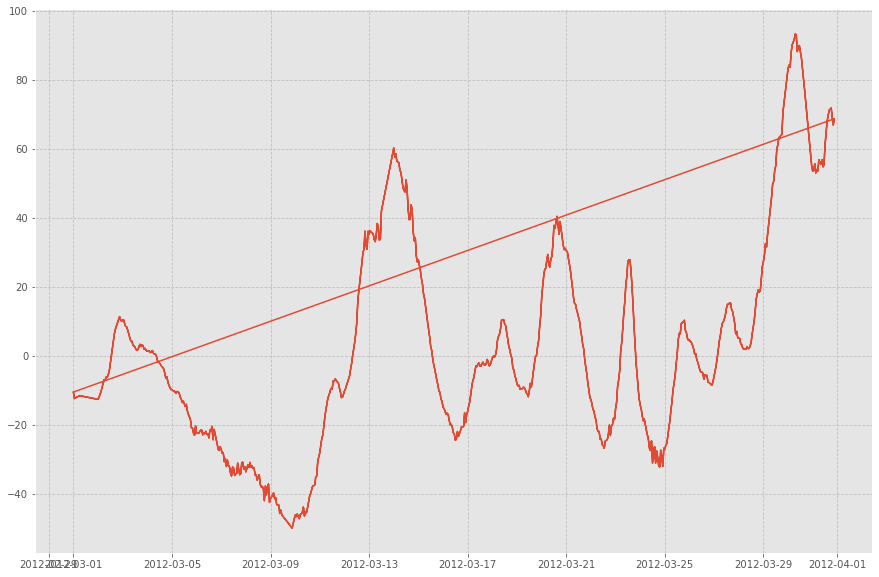

In [32]:
plt.figure(figsize = (15,10))
plt.style.use('ggplot')  # Красивые графики
plt.grid(True, linestyle='--', color='0.75')
y = Itog[Itog['M']==3][Itog['Y']==2012]['Neutr2']
x = Itog[Itog['M']==3][Itog['Y']==2012]['date']
plt.plot(x, y, '-')

In [33]:
#Построение графиков для детекторов от времени
for l in tqdm( range (2012,2019,1) ):
    if ( Itog[Itog['Y'] == l].shape[0] > 1 ) :     
        plt.figure(figsize = (40, 20))
        x = Itog[Itog['Y'] == l]
        for j in range(1,5,1):
            plt.subplot(2,2,j)
            plt.grid(True, linestyle='--', color='0.75')
            plt.xlabel('Время', size = '14')
            plt.ylabel('Поправленные данные', size = '14')
            plt.title('Зависимость темпа счета от времени', size = '16')
            plt.plot(x['date'], x['Neutr%s'%j]/x['Neutr%s'%j].mean(), '.')
    plt.savefig(PATH+ r"/pictures/%s/times_corr.png" %( str(l) ) ) 
    plt.close()

#Построение графиков для детекторов от времени
for l in tqdm( range (2012,2019,1) ):
    for i in range (1,13,1):
        if ( Itog[Itog['M'] == i][Itog['Y'] == l].shape[0] > 1 ) :                        
            plt.figure(figsize = (16, 16))
            x = Itog[Itog['M'] == i][Itog['Y'] == l]
            for j in range(1,5,1):
                plt.subplot(2,2,j)
                plt.grid(True, linestyle='--', color='0.75')
                plt.xlabel('Время', size = '14')
                plt.ylabel('Поправленные данные', size = '14')
                plt.title('Зависимость темпа счета от времени', size = '16')
                plt.plot(x['date'], x['Neutr%s'%j], '.')
            plt.savefig(PATH+ r"/pictures/%s/time_%s.png" %(str(l),str(i))) 
            plt.close()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [34]:
#Построение графиков для детекторов от температуры
for l in tqdm( range (2012,2019,1) ):
    for i in range (1,13,1):
        if ( Itog[Itog['M'] == i][Itog['Y'] == l].shape[0] > 1 ) :                        
            plt.figure(figsize = (16, 16))
            x = Itog[Itog['M'] == i][Itog['Y'] == l]
            for j in range(1,5,1):
                plt.subplot(2,2,j)
                plt.grid(True, linestyle='--', color='0.75')
                plt.xlabel('T, C', size = '14')
                plt.ylabel('Поправленные данные', size = '14')
                plt.title('Зависимость темпа счета от температуры', size = '16')
                plt.plot(x['T, C'], x['Neutr%s'%j], '.')
            plt.savefig(PATH+ r"/pictures/%s/T0_%s.png" %(str(l),str(i))) 
            plt.close()

  0%|          | 0/7 [00:00<?, ?it/s]

In [35]:
#Построение графиков для детекторов от влажности
for l in tqdm( range (2012,2019,1) ):
    for i in range (1,13,1):
        if ( Itog[Itog['M'] == i][Itog['Y'] == l].shape[0] > 1 ) :                        
            plt.figure(figsize = (16, 16))
            x = Itog[Itog['M'] == i][Itog['Y'] == l]
            for j in range(1,5,1):
                plt.subplot(2,2,j)
                plt.grid(True, linestyle='--', color='0.75')
                plt.xlabel('Влажность', size = '14')
                plt.ylabel('Поправленные данные', size = '14')
                plt.title('Зависимость темпа счета от влажности', size = '16')
                plt.plot(x['Humidity'], x['Neutr%s'%j], '.')
            plt.savefig(PATH+ r"/pictures/%s/Hum_%s.png" %(str(l),str(i))) 
            plt.close()

  0%|          | 0/7 [00:00<?, ?it/s]

In [36]:
#Построение графиков для детекторов от давления
for l in tqdm( range (2012,2019,1) ):
    for i in range (1,13,1):
        if ( Itog[Itog['M'] == i][Itog['Y'] == l].shape[0] > 1 ) :                        
            plt.figure(figsize = (16, 16))
            x = Itog[Itog['M'] == i][Itog['Y'] == l]
            for j in range(1,5,1):
                plt.subplot(2,2,j)
                plt.grid(True, linestyle='--', color='0.75')
                plt.xlabel('Давление', size = '14')
                plt.ylabel('Поправленные данные', size = '14')
                plt.title('Зависимость темпа счета от давления', size = '16')
                plt.plot(x['Pressure'], x['Neutr%s'%j], '.')
            plt.savefig(PATH+ r"/pictures/%s/Pres_%s.png" %(str(l),str(i))) 
            plt.close()

  0%|          | 0/7 [00:00<?, ?it/s]

In [37]:
#Построение графиков для давления от времени
for l in tqdm( range (2012,2019,1) ):
    for i in range (1,13,1):
        if ( Itog[Itog['M'] == i][Itog['Y'] == l].shape[0] > 1 ) :                        
            plt.figure(figsize = (10, 10))
            x = Itog[Itog['M'] == i][Itog['Y'] == l]
            plt.grid(True, linestyle='--', color='0.75')
            plt.xlabel('Дата', size = '14')
            plt.ylabel('Давление', size = '14')
            plt.title('Зависимость давления от времени', size = '16')
            plt.plot(x['date'], x['Pressure'], '.')
            plt.savefig(PATH+ r"/pictures/%s/Pres-date%s.png" %(str(l),str(i))) 
            plt.close()

  0%|          | 0/7 [00:00<?, ?it/s]

In [38]:
#Построение графиков для влажности от времени
for l in tqdm( range (2012,2019,1) ):
    for i in range (1,13,1):
        if ( Itog[Itog['M'] == i][Itog['Y'] == l].shape[0] > 1 ) :                        
            plt.figure(figsize = (10, 10))
            x = Itog[Itog['M'] == i][Itog['Y'] == l]
            plt.grid(True, linestyle='--', color='0.75')
            plt.xlabel('Дата', size = '14')
            plt.ylabel('Влажность', size = '14')
            plt.title('Зависимость влажности от времени', size = '16')
            plt.plot(x['date'], x['Humidity'], '.')
            plt.savefig(PATH+ r"/pictures/%s/Hum-date%s.png" %(str(l),str(i))) 
            plt.close()

  0%|          | 0/7 [00:00<?, ?it/s]

In [39]:
#Построение графиков для температуры от времени
for l in tqdm( range (2012,2019,1) ):
    for i in range (1,13,1):
        if ( Itog[Itog['M'] == i][Itog['Y'] == l].shape[0] > 1 ) :                        
            plt.figure(figsize = (10, 10))
            x = Itog[Itog['M'] == i][Itog['Y'] == l]
            plt.grid(True, linestyle='--', color='0.75')
            plt.xlabel('Дата', size = '14')
            plt.ylabel('Температура', size = '14')
            plt.title('Зависимость температуры от времени', size = '16')
            plt.plot(x['date'], x['T, C'], '.')
            plt.savefig(PATH+ r"/pictures/%s/T0-date%s.png" %(str(l),str(i))) 
            plt.close()

  0%|          | 0/7 [00:00<?, ?it/s]